In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('commonlitreadabilityprize/'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

commonlitreadabilityprize/test.csv
commonlitreadabilityprize/train.csv
commonlitreadabilityprize/sample_submission.csv


In [40]:
## more common imports
from collections import Counter
import re
from tqdm import tqdm_notebook as tqdm 

# languange processing imports
import nltk
#nltk.download('punkt')
from gensim.corpora import Dictionary
# preprocessing imports
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

# model imports
from gensim.models.word2vec import Word2Vec
import gensim.downloader as api
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier

# hyperparameter training imports
from sklearn.model_selection import GridSearchCV

# visualization imports
import umap
#import umap.umap_ as umap
from IPython.display import display
import seaborn as sns
import matplotlib.pyplot as plt
import base64
import io
%matplotlib inline
sns.set()  # defines the style

In [ ]:
umap.

In [30]:
# find and remove non-ascii words
# Non so se serva, ma si può modificare aggiungendo preprocessing ad-hoc

our_special_word = 'qwerty'

def remove_ascii_words(df):
    """ removes non-ascii characters from the 'texts' column in df.
    It returns the words containig non-ascii characers.
    """
    non_ascii_words = []
    for i in range(len(df)):
        for word in df.loc[i, 'excerpt'].split(' '):
            if any([ord(character) >= 128 for character in word]):
                non_ascii_words.append(word)
                df.loc[i, 'excerpt'] = df.loc[i, 'excerpt'].replace(word, our_special_word)
    return non_ascii_words

In [31]:
# Non so se serva, ma si può modificare aggiungendo preprocessing ad-hoc
def get_good_tokens(sentence):
    replaced_punctation = list(map(lambda token: re.sub('[^0-9A-Za-z!?]+', '', token), sentence))
    removed_punctation = list(filter(lambda token: token, replaced_punctation))
    return removed_punctation

In [32]:
# Here we get transform the documents into sentences for the word2vecmodel
# we made a function such that later on when we make the submission, we don't need to write duplicate code
def w2v_preprocessing(df):
    """ All the preprocessing steps for word2vec are done in this function.
    All mutations are done on the dataframe itself. So this function returns
    nothing.
    """
    df['excerpt'] = df.excerpt.str.lower()
    df['document_sentences'] = df.excerpt.str.split('.')  # split texts into individual sentences
    df['tokenized_sentences'] = list(map(lambda sentences:
                                         list(map(nltk.word_tokenize, sentences)),
                                         df.document_sentences))  # tokenize sentences
    df['tokenized_sentences'] = list(map(lambda sentences:
                                         list(map(get_good_tokens, sentences)),
                                         df.tokenized_sentences))  # remove unwanted characters
    df['tokenized_sentences'] = list(map(lambda sentences:
                                         list(filter(lambda lst: lst, sentences)),
                                         df.tokenized_sentences))  # remove empty lists

In [33]:
train_data =  pd.read_csv("commonlitreadabilityprize/train.csv")
train_data.head()

,id,url_legal,license,excerpt,target,standard_error
0,c12129c31,NaN,NaN,When the young people returned to the ballroom...,-0.340259,0.464009
1,85aa80a4c,NaN,NaN,"All through dinner time, Mrs. Fayre was somewh...",-0.315372,0.480805
2,b69ac6792,NaN,NaN,"As Roger had predicted, the snow departed as q...",-0.580118,0.476676
3,dd1000b26,NaN,NaN,And outside before the palace a great garden w...,-1.054013,0.450007
4,37c1b32fb,NaN,NaN,Once upon a time there were Three Bears who li...,0.247197,0.510845


In [34]:
train_data.excerpt = train_data['excerpt'].apply(str)
non_ascii_words = remove_ascii_words(train_data)

print("Replaced {} words with characters with an ordinal >= 128 in the test data.".format(
    len(non_ascii_words)))

Replaced 1327 words with characters with an ordinal >= 128 in the test data.


In [ ]:
# Pretrained W2V on Google News
W2Vmodel = api.load('word2vec-google-news-300')

In [35]:
w2v_preprocessing(train_data)

In [17]:
train_data.drop(train_data[train_data.tokenized_sentences.str.len() == 0].index, inplace= True) 

In [18]:
#create dictionary with all sentences
sentences = []
for sentence_group in train_data.tokenized_sentences:
    sentences.extend(sentence_group)

print("Number of sentences: {}.".format(len(sentences)))
print("Number of texts: {}.".format(len(train_data)))

Number of sentences: 25633.
Number of texts: 2834.


In [19]:
def get_w2v_features(w2v_model, sentence_group):
    """ Transform a sentence_group (containing multiple lists
    of words) into a feature vector. It averages out all the
    word vectors of the sentence_group.
    """
    words = np.concatenate(sentence_group)  # words in text
    index2word_set = set(w2v_model.index_to_key) # set(w2v_model.wv.vocab.keys())  # words known to model
    
    featureVec = np.zeros(w2v_model.vector_size, dtype="float32")
    
    # Initialize a counter for number of words in a review
    nwords = 0
    # Loop over each word in the comment and, if it is in the model's vocabulary, add its feature vector to the total
    for word in words:
        if word in index2word_set: 
            featureVec = np.add(featureVec, w2v_model[word])
            nwords += 1.

    # Divide the result by the number of words to get the average
    if nwords > 0:
        featureVec = np.divide(featureVec, nwords)
    return featureVec

In [21]:
train_data['w2v_features'] = list(map(lambda sen_group:
                                     get_w2v_features(W2Vmodel, sen_group),
                                     train_data.tokenized_sentences))

In [22]:
train_data.head()

,id,url_legal,license,excerpt,target,standard_error,document_sentences,tokenized_sentences,w2v_features
0,c12129c31,NaN,NaN,when the young people returned to the ballroom...,-0.340259,0.464009,[when the young people returned to the ballroo...,"[[when, the, young, people, returned, to, the,...","[0.026869211, 0.050346404, 0.016655555, 0.0601..."
1,85aa80a4c,NaN,NaN,"all through dinner time, mrs. fayre was somewh...",-0.315372,0.480805,"[all through dinner time, mrs, fayre was some...","[[all, through, dinner, time, mrs], [fayre, wa...","[0.032734014, 0.028537542, 0.019979037, 0.1107..."
2,b69ac6792,NaN,NaN,"as roger had predicted, the snow departed as q...",-0.580118,0.476676,"[as roger had predicted, the snow departed as ...","[[as, roger, had, predicted, the, snow, depart...","[0.013358668, 0.034155294, 0.046266757, 0.0813..."
3,dd1000b26,NaN,NaN,and outside before the palace a great garden w...,-1.054013,0.450007,[and outside before the palace a great garden ...,"[[and, outside, before, the, palace, a, great,...","[0.05260147, 0.08936741, 0.016588992, 0.086939..."
4,37c1b32fb,NaN,NaN,once upon a time there were three bears who li...,0.247197,0.510845,[once upon a time there were three bears who l...,"[[once, upon, a, time, there, were, three, bea...","[0.052981816, 0.027809488, 0.01056733, 0.14423..."


In [23]:
train_data["w2v_resh_features"] = train_data["w2v_features"].apply(lambda x : x.reshape(1,-1) )

In [24]:
arr_w2v = train_data.w2v_resh_features[0]
for i in range(1, len(train_data)):
    arr_w2v = np.vstack((arr_w2v, train_data.w2v_resh_features[i]))

## UMAP

In [37]:
umap_emb = umap.UMAP(n_neighbors= 15, n_components = 2, target_metric = 'l1' , n_epochs = 500).fit_transform(arr_w2v, y=train_data.target)

AttributeError: module 'umap' has no attribute 'UMAP'

NameError: name 'umap_emb' is not defined

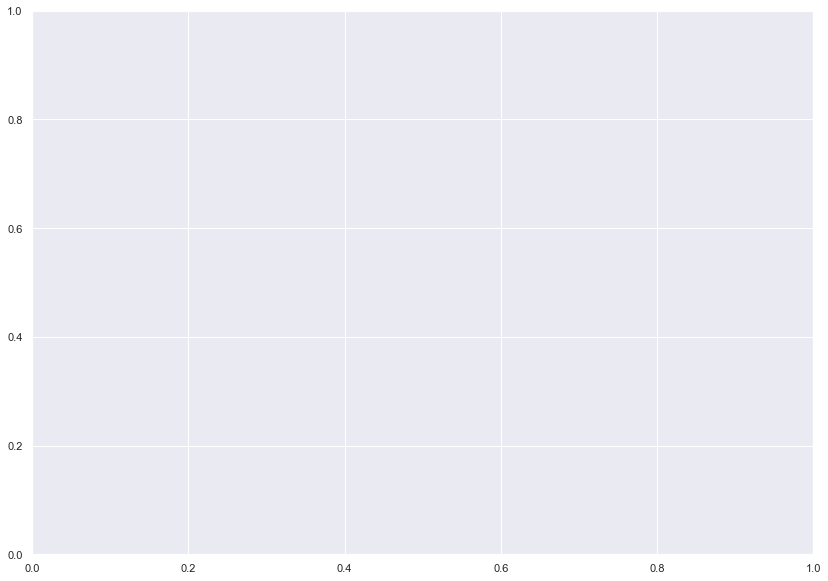

In [26]:
fig, ax = plt.subplots(1, figsize=(14, 10))
plt.scatter(*umap_emb.T, s=0.3, c=train_data.target, cmap='Spectral', alpha=1.0)
plt.setp(ax, xticks=[], yticks=[])
ax.patch.set_facecolor('black')
fg_color = 'white'
cbar = plt.colorbar()
plt.setp(plt.getp(cbar.ax.axes, 'yticklabels'), color=fg_color)

## Validation 

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(
    arr_w2v, train_data.target, test_size=0.05, random_state=42)

In [ ]:
mapper = umap.UMAP(n_neighbors= 15, n_components = 2, target_metric = 'l1' , n_epochs = 1000).fit(X_train, y=y_train)

In [ ]:
val_embedding = mapper.transform(X_val)

In [ ]:
fig, ax = plt.subplots(1, figsize=(14, 10))
plt.scatter(*mapper.embedding_.T, s=3, c=y_train, cmap='Spectral', alpha=1.0)
plt.setp(ax, xticks=[], yticks=[])
ax.patch.set_facecolor('black')
fg_color = 'black'
cbar = plt.colorbar()
plt.setp(plt.getp(cbar.ax.axes, 'yticklabels'), color=fg_color)

In [ ]:
fig, ax = plt.subplots(1, figsize=(14, 10))
plt.scatter(*val_embedding.T, s=3, c=y_val, cmap='Spectral', alpha=1.0)
plt.setp(ax, xticks=[], yticks=[])
ax.patch.set_facecolor('black')
fg_color = 'black'
cbar = plt.colorbar()
plt.setp(plt.getp(cbar.ax.axes, 'yticklabels'), color=fg_color)

### Regression on W2V
Proviamo a vedere se le feature del W2V sono rilevanti per-se 

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error as mse

In [ ]:
reg = GradientBoostingRegressor(random_state=0)
reg.fit(X_train, y_train)

In [ ]:
y_pred = reg.predict(X_val)

In [ ]:
mse(y_val, y_pred) #0.44 not bad, let's see on test :) 

### Augmenting W2V

# Test Data

In [ ]:
test_data =  pd.read_csv("/kaggle/input/commonlitreadabilityprize/test.csv")
test_data.head()

In [ ]:
test_data.excerpt = test_data['excerpt'].apply(str)
non_ascii_words = remove_ascii_words(test_data)

print("Replaced {} words with characters with an ordinal >= 128 in the test data.".format(
    len(non_ascii_words)))

In [ ]:
w2v_preprocessing(test_data)

In [ ]:
test_data.drop(test_data[test_data.tokenized_sentences.str.len() == 0].index, inplace= True) 

In [ ]:
#create dictionary with all sentences
sentences_test = []
for sentence_group in test_data.tokenized_sentences:
    sentences_test.extend(sentence_group)

print("Number of sentences: {}.".format(len(sentences)))
print("Number of texts: {}.".format(len(test_data)))

In [ ]:
test_data['w2v_features'] = list(map(lambda sen_group:
                                     get_w2v_features(W2Vmodel, sen_group),
                                     test_data.tokenized_sentences))

In [ ]:
test_data["w2v_resh_features"] = test_data["w2v_features"].apply(lambda x : x.reshape(1,-1) )

In [ ]:
arr_w2v_test = test_data.w2v_resh_features[0]
for i in range(1, len(test_data)):
    arr_w2v_test = np.vstack((arr_w2v_test, test_data.w2v_resh_features[i]))